# Example of reading ICON-NWP Nawdex simulations, grid and extpar file for Hackathon

0. Set up dask infrastructure
1. Read data
2. Plot mao of total cloud cover for single time step
3. Calculate spatial mean, and plot time series of spatial-mean total cloud cover

Aiko Voigt, KIT; July 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Setup parallel infrastructure: 

One compute node with 8 workers, each having access to 6 threads (so each worker can run at up to 600% CPU)

In [2]:
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs

import dask # Distributed data libary
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources

In [3]:
# Set some user specific variables
account_name = 'bb1018'
partition = 'compute'
job_name = 'nawdexProc' # Job name that is submitted via sbatch
memory = '64GiB' # Max memory per node that is going to be used - this depends on the partition
cores = 48 # Max number of cores per that are reserved - also partition dependent
walltime = '01:00:00' #'12:00:00' # Walltime - also partition dependent

In [4]:
scratch_dir = '/scratch/b/b380459/' # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_scratch_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=partition,
                       name=job_name,
                       processes=8,
                       scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_scratch_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_scratch_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [5]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1018
#SBATCH -n 1
#SBATCH --cpus-per-task=48
#SBATCH --mem=64G
#SBATCH -t 01:00:00
#SBATCH -J nawdexProc
#SBATCH -D /scratch/b/b380459/nawdexProch791q3ji
#SBATCH --begin=now
#SBATCH --output=/scratch/b/b380459/nawdexProch791q3ji/LOG_cluster.%j.o
#SBATCH --output=/scratch/b/b380459/nawdexProch791q3ji/LOG_cluster.%j.o

JOB_ID=${SLURM_JOB_ID%;*}

/pf/b/b380459/conda-envs/Nawdex-Hackathon/bin/python -m distributed.cli.dask_worker tcp://10.50.40.18:45541 --nthreads 6 --nprocs 8 --memory-limit 8.59GB --name name --nanny --death-timeout 60 --local-directory /scratch/b/b380459/nawdexProch791q3ji --interface ib0



In [6]:
cluster.scale(jobs=1)
cluster

In [15]:
! squeue -u $USER #--start

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22803833    shared spawner-  b380459  R    1:02:46      1 m11298


In [10]:
dask_client = Client(cluster)
dask_client

Client Scheduler: tcp://10.50.40.18:45541 Dashboard: http://10.50.40.18:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Helper function for loading data

In [15]:
def load_iconsimulation(expid,gridres):
    
    print('Working on loading data for', expid)
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    
    # 2d datasets
    fname = path+'/'+expid+'/'+expid+'_2016*_2d_30min_DOM01_ML_*.nc'
    print(fname)
    ds_2d_30min = ( xr.open_mfdataset(fname,
                                      combine='by_coords',parallel=True, 
                                      engine='h5netcdf', chunks={'time': 1})
                    [['clct', 'tqv_dia', 'tqc_dia', 'tqi_dia']] )
    
    # grid dataset
    fname = path+'/grids/icon-grid_nawdex_78w40e23n80n_'+gridres+'.nc'
    ds_grid = ( xr.open_dataset(fname)
               [['cell_area','clat','clon','clon_vertices','clat_vertices',
                 'vlon','vlat','vertex_of_cell', 'vertex']].rename({'cell': 'ncells'}) ) 
    # we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
    ds_grid['vertex_of_cell'] = ds_grid['vertex_of_cell'] - 1 
   
    # get land-sea mask from extpar data
    fname = path+'/extpar/extpar_icon-grid_nawdex_78w40e23n80n_'+gridres+'_bitmap.nc'
    ds_extp = xr.open_dataset(fname)[['FR_LAND']].rename({'cell': 'ncells'})
    
    # merge datasets
    ds = xr.merge([ds_2d_30min, ds_grid, ds_extp])
        
    # convert grid from radians to degrees
    ds['clon'] = np.rad2deg(ds['clon'])
    ds['clat'] = np.rad2deg(ds['clat'])
    ds['vlon'] = np.rad2deg(ds['vlon'])
    ds['vlat'] = np.rad2deg(ds['vlat'])
    ds['clon_vertices'] = np.rad2deg(ds['clon_vertices'])
    ds['clat_vertices'] = np.rad2deg(ds['clat_vertices'])
    
    return ds

## Load data from 80km simulation starting on Sep 22, 2016 and using 1-moment microphysics

In [16]:
ds = load_iconsimulation('nawdexnwp-80km-mis-0001','R80000m')

Working on loading data for nawdexnwp-80km-mis-0001
/scratch/b/b380459/icon_4_hackathon//nawdexnwp-80km-mis-0001/nawdexnwp-80km-mis-0001_2016*_2d_30min_DOM01_ML_*.nc


## Plot on triangular grid

For illustration, we plot total cloud cover at time step with index 100.

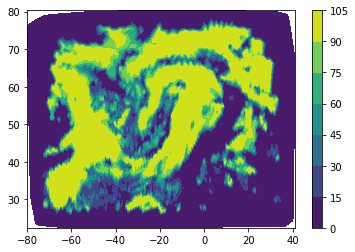

In [17]:
plt.tricontourf(ds.clon, ds.clat, ds['clct'].isel(time=100));
plt.colorbar();

Domain-mean over 50W-10E, 30-70N of swtoacre and clct

## Spatial mean over time

Be careful to only use triangles far enough from the boundaries ...

In [18]:
icells = np.where((ds.clat<70.0) & (ds.clat>30.0) &
                  (ds.clon<10.0) & (ds.clon>-50.0))[0]
ds_aux = ds.isel(ncells=icells)
weights=ds['cell_area']/(ds['cell_area']).sum(dim=['ncells'])
ds_mean = (ds*weights).sum(dim=['ncells'])

## Plot timeseries of mean total cloud cover

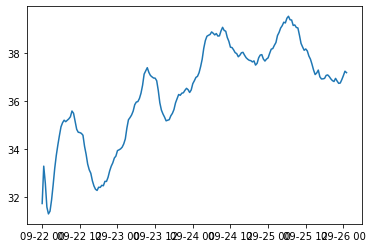

In [19]:
plt.plot(ds.time, ds_mean['clct']);

## Clean up

In [13]:
cluster.close()

## And now: have fun!